## According to the salishseacast results what do we expect to see form the 2017 CIOPS results? How does 2017 compare to other years according to the SSC results?

In [90]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import datetime as dt
from dateutil.relativedelta import relativedelta
import statistics as stat
import scipy
import cmath
from scipy import signal

In [2]:
def get_data(mydata, starttime, endtime):
    transports = (mydata.init_transp[(mydata.final_section != 0) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)])/time
    temp = (mydata.init_temp[(mydata.final_section != 0) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)])
    salt = (mydata.init_salt[(mydata.final_section != 0) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)])
    return np.sum(transports), temp, salt

In [173]:
def check_mask(value):
    if str(type(value)) == "<class 'numpy.float64'>":
        return True
    else:
        return False

In [13]:
dates = np.array([dt.datetime(2016,1,1)+relativedelta(months=i) for i in range(12*5)])
dates[9:15] # = winter 2016/17
dates[15:21] # = summer 2017
dates[21:27] # = winter 2016/2017

array([datetime.datetime(2017, 10, 1, 0, 0),
       datetime.datetime(2017, 11, 1, 0, 0),
       datetime.datetime(2017, 12, 1, 0, 0),
       datetime.datetime(2018, 1, 1, 0, 0),
       datetime.datetime(2018, 2, 1, 0, 0),
       datetime.datetime(2018, 3, 1, 0, 0)], dtype=object)

In [188]:
winter = np.zeros(len(dates))
summer = np.zeros(len(dates))

for i in range(len(dates)):
    if dates[i].month > 3 and dates[i].month < 10:
        winter[i] = False
        summer[i] = True
    else:
        winter[i] = True
        summer[i] = False

In [5]:
yearjumps = [0,1,-2,1,0,1,0,1,1,0,1,0]
str_mo = ['jan', 'feb', 'mar', 'apr','may', 'jun', 'jul', 'aug', 'sep','oct', 'nov', 'dec']
starttime = 1
endtime = 720
time = endtime-starttime+1

sum_trans = np.array([])
avg_temp = np.array([])
max_temp = np.array([])
min_temp = np.array([])
avg_salt = np.array([])
max_salt = np.array([])
min_salt = np.array([])

#2016 and 2017
year = [16,17]

for num in year:
    file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan'+str(num)+'/ariane_positions_quantitative.nc'
    mydata = xr.open_dataset(file)
    for i in range(12):
        tr, te, sa = get_data(mydata, starttime+(i*720+(sum(yearjumps[:i+1]*24))), endtime+(i*720+(sum(yearjumps[:i+1]*24))))
        sum_trans = np.append(sum_trans, tr)
        avg_temp = np.append(avg_temp, np.mean(te))
        max_temp = np.append(max_temp, np.max(te))
        min_temp = np.append(min_temp, np.min(te))
        avg_salt = np.append(avg_salt, np.mean(sa))
        max_salt = np.append(max_salt, np.max(sa))
        min_salt = np.append(min_salt, np.min(sa))

#2019 and 2018 (both done month by month)
year = [18,19]
for num in year:
    for i in range(len(str_mo)):
        file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_1hr/forward_01'+str_mo[i]+str(num)+'/ariane_positions_quantitative.nc'
        mydata = xr.open_dataset(file)
        time = mydata.init_t[-1]
        
        tr, te, sa = get_data(mydata, starttime, endtime)

        sum_trans = np.append(sum_trans, tr)
        avg_temp = np.append(avg_temp, np.mean(te))
        max_temp = np.append(max_temp, np.max(te))
        min_temp = np.append(min_temp, np.min(te))
        avg_salt = np.append(avg_salt, np.mean(sa))
        max_salt = np.append(max_salt, np.max(sa))
        min_salt = np.append(min_salt, np.min(sa))
            
#2020
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan20/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
for i in range(12):
    tr, te, sa = get_data(mydata, starttime+(i*720+(sum(yearjumps[:i+1]*24))), endtime+(i*720+(sum(yearjumps[:i+1]*24))))
    sum_trans = np.append(sum_trans, tr)
    avg_temp = np.append(avg_temp, np.mean(te))
    max_temp = np.append(max_temp, np.max(te))
    min_temp = np.append(min_temp, np.min(te))
    avg_salt = np.append(avg_salt, np.mean(sa))
    max_salt = np.append(max_salt, np.max(sa))
    min_salt = np.append(min_salt, np.min(sa))

## Transport

In [57]:
trans_W = np.ma.array(sum_trans, mask=summer)
trans_S = np.ma.array(sum_trans, mask=winter)

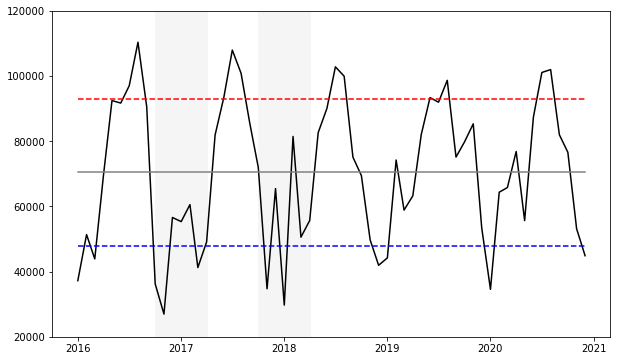

In [23]:
fig, ax = plt.subplots(1,1, figsize=[10,6])
ax.plot(dates, sum_trans, 'k')
ax.plot([dates[0], dates[-1]],[np.mean(sum_trans), np.mean(sum_trans)], 'grey')
ax.plot([dates[0], dates[-1]],[np.mean(sum_trans)+stat.stdev(sum_trans), np.mean(sum_trans)+stat.stdev(sum_trans)], 'r--')
ax.plot([dates[0], dates[-1]],[np.mean(sum_trans)-stat.stdev(sum_trans), np.mean(sum_trans)-stat.stdev(sum_trans)], 'b--')
ax.set_ylim([20000,120000])

ax.fill_between(dates, 20000, 120000, where=(dates<dates[15+1])&(dates>=dates[9]), color='whitesmoke')
ax.fill_between(dates, 20000, 120000, where=(dates<dates[27+1])&(dates>=dates[21]), color='whitesmoke')

In [225]:
fft = scipy.fft.fft(sum_trans)
power = np.abs(fft)
freq = scipy.fft.fftfreq(len(fft),d=1)

peaks = signal.find_peaks(power, prominence=11.1**5)[0]
peak_freq =  freq[peaks]
peak_power = power[peaks]

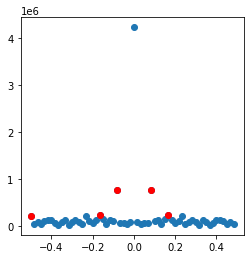

In [227]:
fig, ax = plt.subplots(1,1, figsize=[4,4])
ax.scatter(freq, power)
ax.scatter(peak_freq,peak_power,color='r')

In [228]:
fft_filtered = np.zeros(len(fft),dtype=np.complex_)
for i in peaks:
    fft_filtered[i] = fft[i]

/home/rbeutel/anaconda3/envs/Ariane/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(20000.0, 120000.0)

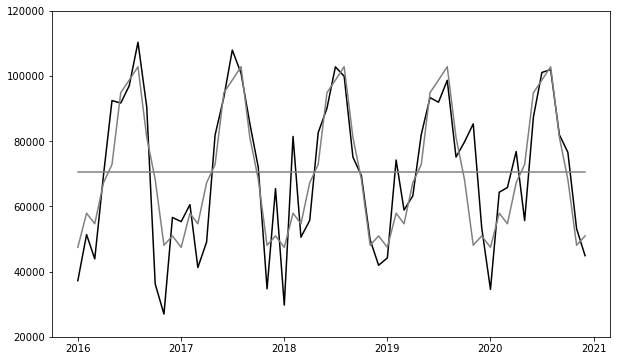

In [229]:
fig, ax = plt.subplots(1,1, figsize=[10,6])
ax.plot(dates, sum_trans, 'k')
ax.plot(dates, scipy.fft.ifft(fft_filtered)+np.mean(sum_trans), color='grey')
# ax.plot([dates[0], dates[-1]],[np.mean(trans_S), np.mean(trans_S)], 'r--', label="average summer transport")
# ax.plot([dates[0], dates[-1]],[np.mean(trans_W), np.mean(trans_W)], 'b--', label="average winter transport")
ax.plot([dates[0], dates[-1]],[np.mean(sum_trans), np.mean(sum_trans)], 'grey')
# ax.plot([dates[0], dates[-1]],[np.mean(sum_trans)+stat.stdev(sum_trans), np.mean(sum_trans)+stat.stdev(sum_trans)], 'r--')
# ax.plot([dates[0], dates[-1]],[np.mean(sum_trans)-stat.stdev(sum_trans), np.mean(sum_trans)-stat.stdev(sum_trans)], 'b--')
ax.set_ylim([20000,120000])

In [230]:
# remove seasonal cycle
trans = sum_trans - (scipy.fft.ifft(fft_filtered)+np.mean(sum_trans))

In [231]:
anomW = np.array(list(filter(check_mask, np.ma.array(trans.real, mask=summer)))) 
anomS = np.array(list(filter(check_mask, np.ma.array(trans.real, mask=winter)))) 

/home/rbeutel/anaconda3/envs/Ariane/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


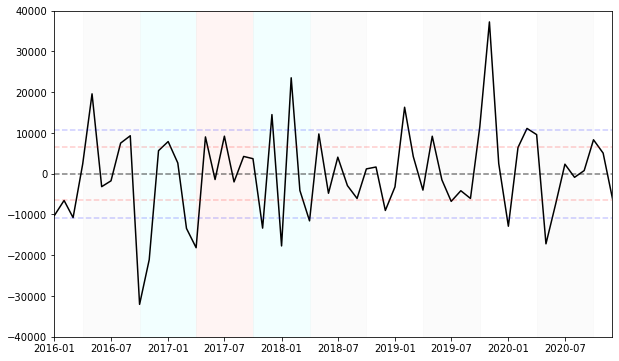

In [232]:
fig, ax = plt.subplots(1,1, figsize=[10,6])

ax.plot(dates, trans, 'k')
ax.plot([dates[0],dates[-1]], [0,0], 'k--', alpha=0.5)
ax.plot([dates[0],dates[-1]], [np.mean(abs(anomW)),np.mean(abs(anomW))], 'b--', alpha=0.2)
ax.plot([dates[0],dates[-1]], [-np.mean(abs(anomW)),-np.mean(abs(anomW))], 'b--', alpha=0.2)
ax.plot([dates[0],dates[-1]], [np.mean(abs(anomS)),np.mean(abs(anomS))], 'r--', alpha=0.2)
ax.plot([dates[0],dates[-1]], [-np.mean(abs(anomS)),-np.mean(abs(anomS))], 'r--', alpha=0.2)
ax.set_ylim([-40000,40000])
ax.set_xlim([dates[0],dates[-1]])

ax.fill_between(dates, -40000,40000, where=(dates<dates[15+1])&(dates>=dates[9]), color='lightcyan', alpha=0.4)
ax.fill_between(dates, -40000,40000, where=(dates<dates[21+1])&(dates>=dates[15]), color='mistyrose', alpha=0.4)
ax.fill_between(dates, -40000,40000, where=(dates<dates[27+1])&(dates>=dates[21]), color='lightcyan', alpha=0.4)

ax.fill_between(dates, -40000,40000, where=(dates<dates[9+1])&(dates>=dates[3]), color='whitesmoke', alpha=0.4)
ax.fill_between(dates, -40000,40000, where=(dates<dates[33+1])&(dates>=dates[27]), color='whitesmoke', alpha=0.4)
ax.fill_between(dates, -40000,40000, where=(dates<dates[45+1])&(dates>=dates[39]), color='whitesmoke', alpha=0.4)
ax.fill_between(dates, -40000,40000, where=(dates<dates[57+1])&(dates>=dates[51]), color='whitesmoke', alpha=0.4)

#### winter 2016/17
- very low flows in the beginning and end of the season
- otherwise only slightly above average flow for the rest of the winter

#### summer 2017
- flows on the higher side but nothing to write home about

#### winter 2017/18
- very variable, switching back and forth between anomalously high and low flows

## Temperature

Text(0, 0.5, 'Temperature $^\\circ C$')

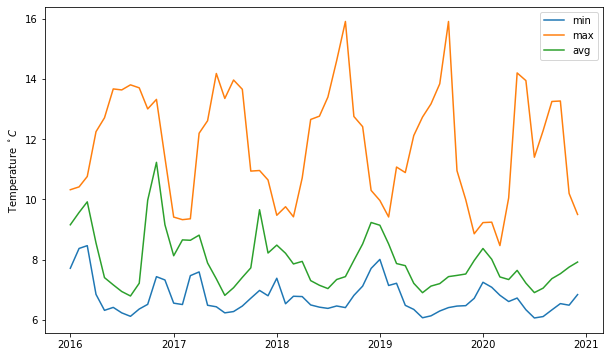

In [9]:
fig, ax = plt.subplots(1,1, figsize=[10,6])

ax.plot(dates, min_temp, label='min')
ax.plot(dates, max_temp, label='max')
ax.plot(dates, avg_temp, label='avg')
ax.legend()
ax.set_ylabel('Temperature $^\circ C$')

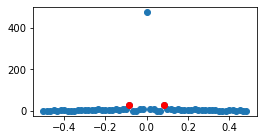

In [239]:
# lets remove the seasonal cycle of ALL OF THEM
# first average

fft = scipy.fft.fft(avg_temp)
power = np.abs(fft)
freq = scipy.fft.fftfreq(len(fft),d=1)

peaks = signal.find_peaks(power, prominence=7)[0]
peak_freq =  freq[peaks]
peak_power = power[peaks]

fig, ax = plt.subplots(1,1, figsize=[4,2])
ax.scatter(freq, power)
ax.scatter(peak_freq,peak_power,color='r')

In [237]:
fft_filtered = np.zeros(len(fft),dtype=np.complex_)
for i in peaks:
    fft_filtered[i] = fft[i]
    
seas_avg = scipy.fft.ifft(fft_filtered)+np.mean(avg_temp)

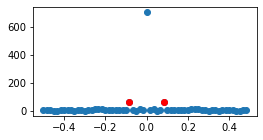

In [243]:
# now max

fft = scipy.fft.fft(max_temp)
power = np.abs(fft)
freq = scipy.fft.fftfreq(len(fft),d=1)

peaks = signal.find_peaks(power, prominence=11)[0]
peak_freq =  freq[peaks]
peak_power = power[peaks]

fig, ax = plt.subplots(1,1, figsize=[4,2])
ax.scatter(freq, power)
ax.scatter(peak_freq,peak_power,color='r')

In [244]:
fft_filtered = np.zeros(len(fft),dtype=np.complex_)
for i in peaks:
    fft_filtered[i] = fft[i]
    
seas_max = scipy.fft.ifft(fft_filtered)+np.mean(max_temp)

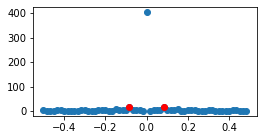

In [245]:
# now min

fft = scipy.fft.fft(min_temp)
power = np.abs(fft)
freq = scipy.fft.fftfreq(len(fft),d=1)

peaks = signal.find_peaks(power, prominence=6)[0]
peak_freq =  freq[peaks]
peak_power = power[peaks]

fig, ax = plt.subplots(1,1, figsize=[4,2])
ax.scatter(freq, power)
ax.scatter(peak_freq,peak_power,color='r')

In [246]:
fft_filtered = np.zeros(len(fft),dtype=np.complex_)
for i in peaks:
    fft_filtered[i] = fft[i]
    
seas_min = scipy.fft.ifft(fft_filtered)+np.mean(min_temp)

/home/rbeutel/anaconda3/envs/Ariane/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/rbeutel/anaconda3/envs/Ariane/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/rbeutel/anaconda3/envs/Ariane/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'Temperature $^\\circ C$')

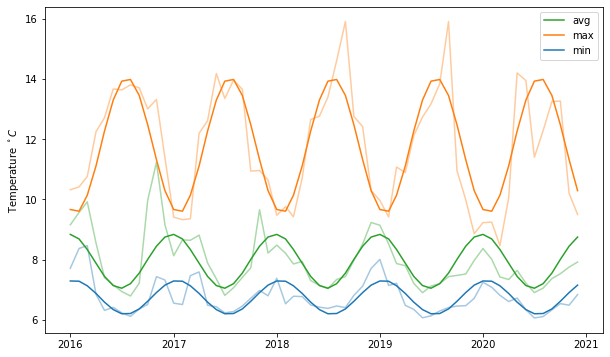

In [247]:
fig, ax = plt.subplots(1,1, figsize=[10,6])

ax.plot(dates, min_temp, alpha=0.4)
ax.plot(dates, max_temp, alpha=0.4)
ax.plot(dates, avg_temp, alpha=0.4)
ax.plot(dates, seas_avg, label='avg', color='tab:green')
ax.plot(dates, seas_max, label='max', color='tab:orange')
ax.plot(dates, seas_min, label='min', color='tab:blue')
ax.legend()
ax.set_ylabel('Temperature $^\circ C$')

/home/rbeutel/anaconda3/envs/Ariane/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/rbeutel/anaconda3/envs/Ariane/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/rbeutel/anaconda3/envs/Ariane/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


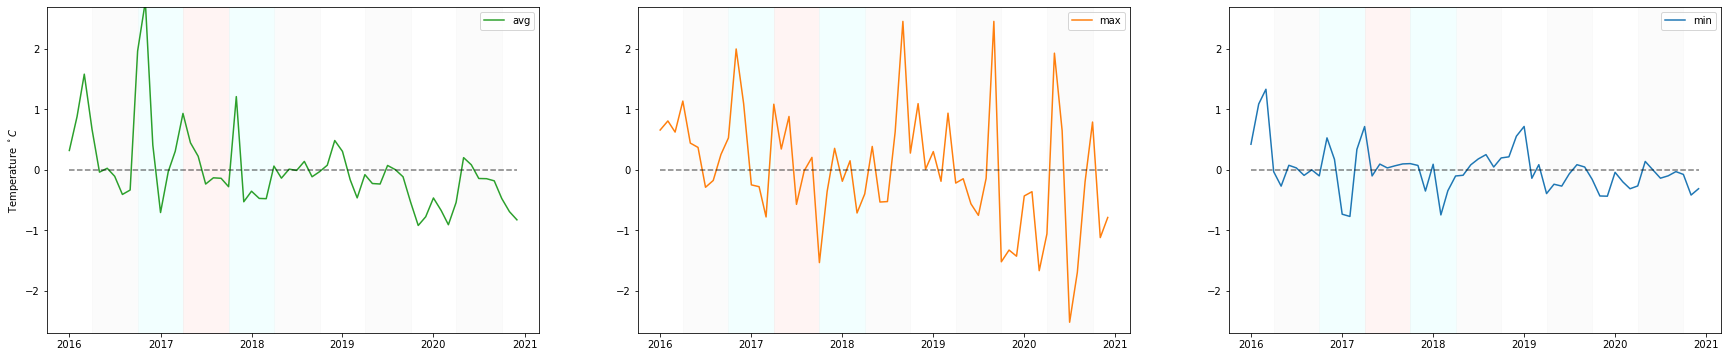

In [258]:
fig, ax = plt.subplots(1,3, figsize=[30,6])

ax[0].plot(dates, avg_temp - seas_avg, label='avg', color='tab:green')
ax[1].plot(dates, max_temp - seas_max, label='max', color='tab:orange')
ax[2].plot(dates, min_temp - seas_min, label='min', color='tab:blue')
ax[0].plot([dates[0], dates[-1]], [0,0], 'k--', alpha=0.5)
ax[1].plot([dates[0], dates[-1]], [0,0], 'k--', alpha=0.5)
ax[2].plot([dates[0], dates[-1]], [0,0], 'k--', alpha=0.5)
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[0].set_ylabel('Temperature $^\circ C$')

ax[0].set_ylim([-2.7, 2.7])
ax[1].set_ylim([-2.7, 2.7])
ax[2].set_ylim([-2.7, 2.7])

ax[0].fill_between(dates, -2.7,2.7, where=(dates<dates[15+1])&(dates>=dates[9]), color='lightcyan', alpha=0.4)
ax[0].fill_between(dates, -2.7,2.7, where=(dates<dates[21+1])&(dates>=dates[15]), color='mistyrose', alpha=0.4)
ax[0].fill_between(dates, -2.7,2.7, where=(dates<dates[27+1])&(dates>=dates[21]), color='lightcyan', alpha=0.4)

ax[0].fill_between(dates, -2.7,2.7, where=(dates<dates[9+1])&(dates>=dates[3]), color='whitesmoke', alpha=0.4)
ax[0].fill_between(dates, -2.7,2.7, where=(dates<dates[33+1])&(dates>=dates[27]), color='whitesmoke', alpha=0.4)
ax[0].fill_between(dates, -2.7,2.7, where=(dates<dates[45+1])&(dates>=dates[39]), color='whitesmoke', alpha=0.4)
ax[0].fill_between(dates, -2.7,2.7, where=(dates<dates[57+1])&(dates>=dates[51]), color='whitesmoke', alpha=0.4)

ax[1].fill_between(dates, -2.7,2.7, where=(dates<dates[15+1])&(dates>=dates[9]), color='lightcyan', alpha=0.4)
ax[1].fill_between(dates, -2.7,2.7, where=(dates<dates[21+1])&(dates>=dates[15]), color='mistyrose', alpha=0.4)
ax[1].fill_between(dates, -2.7,2.7, where=(dates<dates[27+1])&(dates>=dates[21]), color='lightcyan', alpha=0.4)

ax[1].fill_between(dates, -2.7,2.7, where=(dates<dates[9+1])&(dates>=dates[3]), color='whitesmoke', alpha=0.4)
ax[1].fill_between(dates, -2.7,2.7, where=(dates<dates[33+1])&(dates>=dates[27]), color='whitesmoke', alpha=0.4)
ax[1].fill_between(dates, -2.7,2.7, where=(dates<dates[45+1])&(dates>=dates[39]), color='whitesmoke', alpha=0.4)
ax[1].fill_between(dates, -2.7,2.7, where=(dates<dates[57+1])&(dates>=dates[51]), color='whitesmoke', alpha=0.4)

ax[2].fill_between(dates, -2.7,2.7, where=(dates<dates[15+1])&(dates>=dates[9]), color='lightcyan', alpha=0.4)
ax[2].fill_between(dates, -2.7,2.7, where=(dates<dates[21+1])&(dates>=dates[15]), color='mistyrose', alpha=0.4)
ax[2].fill_between(dates, -2.7,2.7, where=(dates<dates[27+1])&(dates>=dates[21]), color='lightcyan', alpha=0.4)

ax[2].fill_between(dates, -2.7,2.7, where=(dates<dates[9+1])&(dates>=dates[3]), color='whitesmoke', alpha=0.4)
ax[2].fill_between(dates, -2.7,2.7, where=(dates<dates[33+1])&(dates>=dates[27]), color='whitesmoke', alpha=0.4)
ax[2].fill_between(dates, -2.7,2.7, where=(dates<dates[45+1])&(dates>=dates[39]), color='whitesmoke', alpha=0.4)
ax[2].fill_between(dates, -2.7,2.7, where=(dates<dates[57+1])&(dates>=dates[51]), color='whitesmoke', alpha=0.4)

- max value range significant compared to min

#### winter 2016/17
- highest average temperature in the timeseries observed
- late cooling of maximum inflow
- variable minimum temperature

#### summer 2017
- follows the seasonal reasonbly well

#### winter 2017/18
- slightly low min and average but follows the cycle reasonably well

## Salinity

Text(0, 0.5, 'Salinity $g kg^{-1}$')

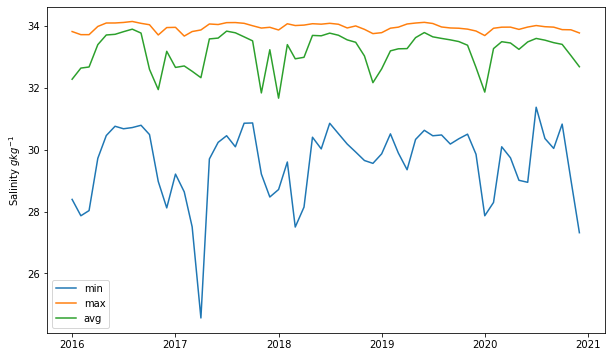

In [11]:
fig, ax = plt.subplots(1,1, figsize=[10,6])

ax.plot(dates, min_salt, label='min')
ax.plot(dates, max_salt, label='max')
ax.plot(dates, avg_salt, label='avg')
ax.legend()
ax.set_ylabel('Salinity $g kg^{-1}$')

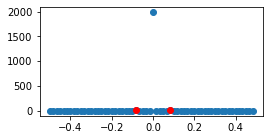

In [259]:
# lets remove the seasonal cycle of ALL OF THEM
# first average

fft = scipy.fft.fft(avg_salt)
power = np.abs(fft)
freq = scipy.fft.fftfreq(len(fft),d=1)

peaks = signal.find_peaks(power, prominence=7)[0]
peak_freq =  freq[peaks]
peak_power = power[peaks]

fig, ax = plt.subplots(1,1, figsize=[4,2])
ax.scatter(freq, power)
ax.scatter(peak_freq,peak_power,color='r')

In [260]:
fft_filtered = np.zeros(len(fft),dtype=np.complex_)
for i in peaks:
    fft_filtered[i] = fft[i]
    
seas_avg = scipy.fft.ifft(fft_filtered)+np.mean(avg_salt)

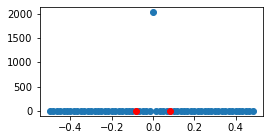

In [263]:
fft = scipy.fft.fft(max_salt)
power = np.abs(fft)
freq = scipy.fft.fftfreq(len(fft),d=1)

peaks = signal.find_peaks(power, prominence=3)[0]
peak_freq =  freq[peaks]
peak_power = power[peaks]

fig, ax = plt.subplots(1,1, figsize=[4,2])
ax.scatter(freq, power)
ax.scatter(peak_freq,peak_power,color='r')

In [264]:
fft_filtered = np.zeros(len(fft),dtype=np.complex_)
for i in peaks:
    fft_filtered[i] = fft[i]
    
seas_max = scipy.fft.ifft(fft_filtered)+np.mean(max_salt)

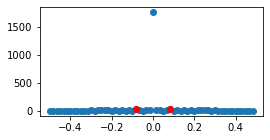

In [266]:
fft = scipy.fft.fft(min_salt)
power = np.abs(fft)
freq = scipy.fft.fftfreq(len(fft),d=1)

peaks = signal.find_peaks(power, prominence=10)[0]
peak_freq =  freq[peaks]
peak_power = power[peaks]

fig, ax = plt.subplots(1,1, figsize=[4,2])
ax.scatter(freq, power)
ax.scatter(peak_freq,peak_power,color='r')

In [267]:
fft_filtered = np.zeros(len(fft),dtype=np.complex_)
for i in peaks:
    fft_filtered[i] = fft[i]
    
seas_min = scipy.fft.ifft(fft_filtered)+np.mean(min_salt)

/home/rbeutel/anaconda3/envs/Ariane/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/rbeutel/anaconda3/envs/Ariane/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/rbeutel/anaconda3/envs/Ariane/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


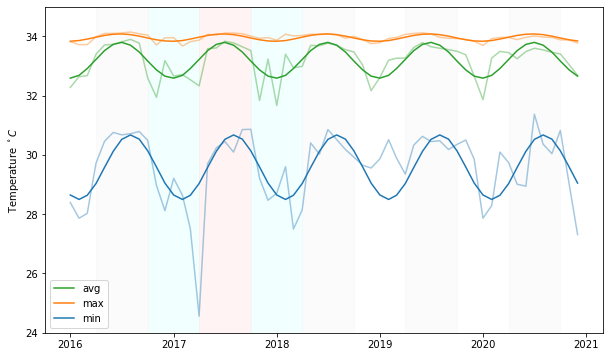

In [275]:
fig, ax = plt.subplots(1,1, figsize=[10,6])

ax.plot(dates, min_salt, alpha=0.4)
ax.plot(dates, max_salt, alpha=0.4)
ax.plot(dates, avg_salt, alpha=0.4)
ax.plot(dates, seas_avg, label='avg', color='tab:green')
ax.plot(dates, seas_max, label='max', color='tab:orange')
ax.plot(dates, seas_min, label='min', color='tab:blue')
ax.set_ylim([24,35])
ax.legend()
ax.set_ylabel('Temperature $^\circ C$')

ax.fill_between(dates, -40000,40000, where=(dates<dates[15+1])&(dates>=dates[9]), color='lightcyan', alpha=0.4)
ax.fill_between(dates, -40000,40000, where=(dates<dates[21+1])&(dates>=dates[15]), color='mistyrose', alpha=0.4)
ax.fill_between(dates, -40000,40000, where=(dates<dates[27+1])&(dates>=dates[21]), color='lightcyan', alpha=0.4)

ax.fill_between(dates, -40000,40000, where=(dates<dates[9+1])&(dates>=dates[3]), color='whitesmoke', alpha=0.4)
ax.fill_between(dates, -40000,40000, where=(dates<dates[33+1])&(dates>=dates[27]), color='whitesmoke', alpha=0.4)
ax.fill_between(dates, -40000,40000, where=(dates<dates[45+1])&(dates>=dates[39]), color='whitesmoke', alpha=0.4)
ax.fill_between(dates, -40000,40000, where=(dates<dates[57+1])&(dates>=dates[51]), color='whitesmoke', alpha=0.4)

/home/rbeutel/anaconda3/envs/Ariane/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/rbeutel/anaconda3/envs/Ariane/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/rbeutel/anaconda3/envs/Ariane/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


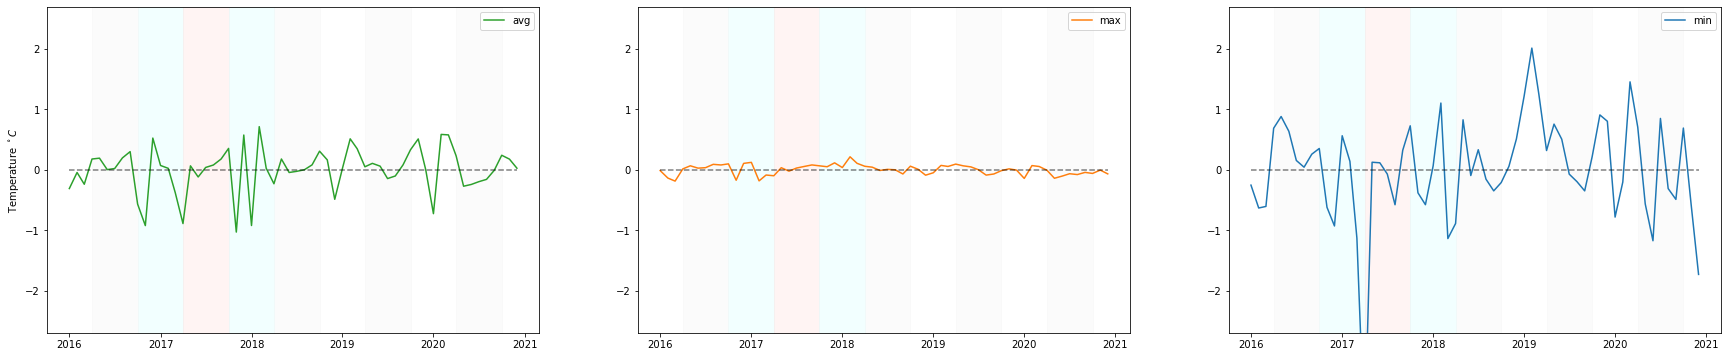

In [269]:
fig, ax = plt.subplots(1,3, figsize=[30,6])

ax[0].plot(dates, avg_salt - seas_avg, label='avg', color='tab:green')
ax[1].plot(dates, max_salt - seas_max, label='max', color='tab:orange')
ax[2].plot(dates, min_salt - seas_min, label='min', color='tab:blue')
ax[0].plot([dates[0], dates[-1]], [0,0], 'k--', alpha=0.5)
ax[1].plot([dates[0], dates[-1]], [0,0], 'k--', alpha=0.5)
ax[2].plot([dates[0], dates[-1]], [0,0], 'k--', alpha=0.5)
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[0].set_ylabel('Temperature $^\circ C$')

ax[0].set_ylim([-2.7, 2.7])
ax[1].set_ylim([-2.7, 2.7])
ax[2].set_ylim([-2.7, 2.7])

ax[0].fill_between(dates, -2.7,2.7, where=(dates<dates[15+1])&(dates>=dates[9]), color='lightcyan', alpha=0.4)
ax[0].fill_between(dates, -2.7,2.7, where=(dates<dates[21+1])&(dates>=dates[15]), color='mistyrose', alpha=0.4)
ax[0].fill_between(dates, -2.7,2.7, where=(dates<dates[27+1])&(dates>=dates[21]), color='lightcyan', alpha=0.4)

ax[0].fill_between(dates, -2.7,2.7, where=(dates<dates[9+1])&(dates>=dates[3]), color='whitesmoke', alpha=0.4)
ax[0].fill_between(dates, -2.7,2.7, where=(dates<dates[33+1])&(dates>=dates[27]), color='whitesmoke', alpha=0.4)
ax[0].fill_between(dates, -2.7,2.7, where=(dates<dates[45+1])&(dates>=dates[39]), color='whitesmoke', alpha=0.4)
ax[0].fill_between(dates, -2.7,2.7, where=(dates<dates[57+1])&(dates>=dates[51]), color='whitesmoke', alpha=0.4)

ax[1].fill_between(dates, -2.7,2.7, where=(dates<dates[15+1])&(dates>=dates[9]), color='lightcyan', alpha=0.4)
ax[1].fill_between(dates, -2.7,2.7, where=(dates<dates[21+1])&(dates>=dates[15]), color='mistyrose', alpha=0.4)
ax[1].fill_between(dates, -2.7,2.7, where=(dates<dates[27+1])&(dates>=dates[21]), color='lightcyan', alpha=0.4)

ax[1].fill_between(dates, -2.7,2.7, where=(dates<dates[9+1])&(dates>=dates[3]), color='whitesmoke', alpha=0.4)
ax[1].fill_between(dates, -2.7,2.7, where=(dates<dates[33+1])&(dates>=dates[27]), color='whitesmoke', alpha=0.4)
ax[1].fill_between(dates, -2.7,2.7, where=(dates<dates[45+1])&(dates>=dates[39]), color='whitesmoke', alpha=0.4)
ax[1].fill_between(dates, -2.7,2.7, where=(dates<dates[57+1])&(dates>=dates[51]), color='whitesmoke', alpha=0.4)

ax[2].fill_between(dates, -2.7,2.7, where=(dates<dates[15+1])&(dates>=dates[9]), color='lightcyan', alpha=0.4)
ax[2].fill_between(dates, -2.7,2.7, where=(dates<dates[21+1])&(dates>=dates[15]), color='mistyrose', alpha=0.4)
ax[2].fill_between(dates, -2.7,2.7, where=(dates<dates[27+1])&(dates>=dates[21]), color='lightcyan', alpha=0.4)

ax[2].fill_between(dates, -2.7,2.7, where=(dates<dates[9+1])&(dates>=dates[3]), color='whitesmoke', alpha=0.4)
ax[2].fill_between(dates, -2.7,2.7, where=(dates<dates[33+1])&(dates>=dates[27]), color='whitesmoke', alpha=0.4)
ax[2].fill_between(dates, -2.7,2.7, where=(dates<dates[45+1])&(dates>=dates[39]), color='whitesmoke', alpha=0.4)
ax[2].fill_between(dates, -2.7,2.7, where=(dates<dates[57+1])&(dates>=dates[51]), color='whitesmoke', alpha=0.4)

- min value range significant, max range is tiny
- max and average trough occurs in Januarybut min is in February

#### winter 2016/17
- lowest salt inlfow in timseries in april of 2017, march also low

#### summer 2017
- all parameters follow the seasonal reasonbly well, fluctuation above and bellow expected

#### winter 2017/18
- max follows the seasonal well
- the min is relatively good but like all other winters lots of fluctuation
- more fluctuation in the average than in other winters, looks similar to transport fluctuation in this same year